In [1]:
from lib.utils import *
from lib.datasets import Dataset2p0
from torch.utils.data import DataLoader
import torch
from torch import nn
from lib.env import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from lib.utils import UniformRandomClassifier,ProportionalRandomClassifier
def get_trainloader(train_ids):
    X_train = torch.Tensor()
    y_train = torch.Tensor()
    for id in train_ids:
        for condition in ['Vehicle','PF']:
            df = pd.read_csv(f'../data/ekyn_with_psd/{id}/{condition}.csv')
            Xi = df.drop(['Time Stamp','label'],axis=1)
            Xi = torch.from_numpy(Xi.to_numpy()).float()
            df[df['label'] == 'X'] = pd.NA
            df = df.fillna(method='ffill')
            yi = one_hot(torch.from_numpy(pd.Categorical(df['label']).codes.copy()).long()).float()
            X_train = torch.cat([X_train,Xi])
            y_train = torch.cat([y_train,yi])
    return X_train,y_train
def get_testloader(test_id):
    X_test = torch.Tensor()
    y_test = torch.Tensor()
    for condition in ['Vehicle','PF']:
        df = pd.read_csv(f'../data/ekyn_with_psd/{test_id}/{condition}.csv')
        Xi = df.drop(['Time Stamp','label'],axis=1)
        Xi = torch.from_numpy(Xi.to_numpy()).float()
        df[df['label'] == 'X'] = pd.NA
        df = df.fillna(method='ffill')
        yi = one_hot(torch.from_numpy(pd.Categorical(df['label']).codes.copy()).long()).float()
        X_test = torch.cat([X_test,Xi])
        y_test = torch.cat([y_test,yi])
    return X_test,y_test
def get_trainloader_windowed(train_ids):
    windowsize = 5
    X_train = torch.Tensor()
    y_train = torch.Tensor()
    for id in train_ids:
        for condition in ['Vehicle','PF']:
            df = pd.read_csv(f'../data/ekyn_with_psd/{id}/{condition}.csv')
            Xi = df.drop(['Time Stamp','label'],axis=1)
            Xi = torch.from_numpy(Xi.to_numpy()).float()
            df[df['label'] == 'X'] = pd.NA
            df = df.fillna(method='ffill')
            yi = one_hot(torch.from_numpy(pd.Categorical(df['label']).codes.copy()).long()).float()

            Xi = torch.cat([torch.zeros(windowsize//2,42),Xi,torch.zeros(windowsize//2,42)]) # zero padding
            cat = [Xi[:-(windowsize-1)]]
            for i in range(1,(windowsize-1)):
                cat.append(Xi[i:i-(windowsize-1)])
            cat.append(Xi[(windowsize-1):])
            Xi = torch.cat(cat,axis=1).float()

            X_train = torch.cat([X_train,Xi])
            y_train = torch.cat([y_train,yi])
    return X_train,y_train
def get_testloader_windowed(test_id):
    windowsize = 5
    X_test = torch.Tensor()
    y_test = torch.Tensor()
    for condition in ['Vehicle','PF']:
        df = pd.read_csv(f'../data/ekyn_with_psd/{test_id}/{condition}.csv')
        Xi = df.drop(['Time Stamp','label'],axis=1)
        Xi = torch.from_numpy(Xi.to_numpy()).float()
        df[df['label'] == 'X'] = pd.NA
        df = df.fillna(method='ffill')
        yi = one_hot(torch.from_numpy(pd.Categorical(df['label']).codes.copy()).long()).float()

        Xi = torch.cat([torch.zeros(windowsize//2,42),Xi,torch.zeros(windowsize//2,42)]) # zero padding
        cat = [Xi[:-(windowsize-1)]]
        for i in range(1,(windowsize-1)):
            cat.append(Xi[i:i-(windowsize-1)])
        cat.append(Xi[(windowsize-1):])
        Xi = torch.cat(cat,axis=1).float()

        X_test = torch.cat([X_test,Xi])
        y_test = torch.cat([y_test,yi])
    return X_test,y_test

/home/andrew/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
eval = []

In [3]:
for (train_ids,test_id) in tqdm(get_leave_one_out_cv_ids_for_ekyn()):
    X_train,y_train = get_trainloader_windowed(train_ids)

    clf = RandomForestClassifier()
    clf.fit(X_train,y_train)

    X_test,y_test = get_testloader_windowed(test_id)

    y_pred = clf.predict(X_test)
    cm_grid(y_test.argmax(axis=1),y_pred.argmax(axis=1))
    eval.append(metrics(y_test,y_pred))

 75%|███████▌  | 12/16 [1:34:04<31:40, 475.07s/it] 

In [ ]:
df = pd.DataFrame([[fold['precision'] for fold in np.load('proportional_random_eval_unscaled.npy',allow_pickle=True)],
    [fold['recall'] for fold in np.load('proportional_random_eval_unscaled.npy',allow_pickle=True)],
    [fold['f1'] for fold in np.load('proportional_random_eval_unscaled.npy',allow_pickle=True)],['proportional']*16],index=['precision','recall','f1','classifier']).T
df = pd.concat([df,pd.DataFrame([[fold['precision'] for fold in np.load('uniform_random_eval_unscaled.npy',allow_pickle=True)],
    [fold['recall'] for fold in np.load('uniform_random_eval_unscaled.npy',allow_pickle=True)],
    [fold['f1'] for fold in np.load('uniform_random_eval_unscaled.npy',allow_pickle=True)],['uniform']*16],index=['precision','recall','f1','classifier']).T])
df = pd.concat([df,pd.DataFrame([[fold['precision'] for fold in np.load('mlp_eval_unscaled.npy',allow_pickle=True)],
    [fold['recall'] for fold in np.load('mlp_eval_unscaled.npy',allow_pickle=True)],
    [fold['f1'] for fold in np.load('mlp_eval_unscaled.npy',allow_pickle=True)],['mlp']*16],index=['precision','recall','f1','classifier']).T])
df = pd.concat([df,pd.DataFrame([[fold['precision'] for fold in np.load('rf_eval_unscaled.npy',allow_pickle=True)],
    [fold['recall'] for fold in np.load('rf_eval_unscaled.npy',allow_pickle=True)],
    [fold['f1'] for fold in np.load('rf_eval_unscaled.npy',allow_pickle=True)],['rf']*16],index=['precision','recall','f1','classifier']).T])
df[['precision','recall','f1']] = df[['precision','recall','f1']].astype(float)
df['classifier'] = df['classifier'].astype(str)
df = df.reset_index(drop=True)
sns.violinplot(data=df,x='f1',y='classifier',split=True)

In [ ]:
df[df['classifier'] == 'rf'].describe()

In [ ]:
df[df['classifier'] == 'mlp'].describe()

{'precision': 0.9458530204212366,
 'recall': 0.8257858683041287,
 'f1': 0.8749927027607033}

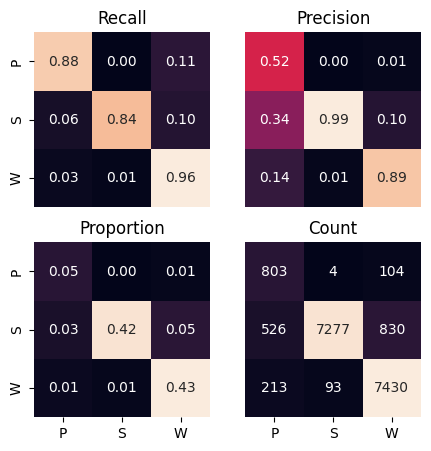

In [133]:
train_ids,test_id = get_leave_one_out_cv_ids_for_ekyn()[0]
X_train,y_train = get_trainloader_windowed(train_ids)

clf = RandomForestClassifier()
clf.fit(X_train,y_train)

X_test,y_test = get_testloader_windowed(test_id)

y_pred = clf.predict(X_test)
cm_grid(y_test.argmax(axis=1),y_pred.argmax(axis=1))
metrics(y_test,y_pred)